In [12]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/lukbrunn/Documents/Scripts/utils')

from get_filenames import Filenames

varns = ['tas', 'pr']
scenarios = ['rcp26', 'rcp45', 'rcp85']

fn = Filenames('{varn}/{varn}_sea_CSIRO-Mk3-6-0_{scenario}_{ensemble}_g025.nc')
fn.apply_filter(varn=varns, scenario=scenarios)

ds_varns = []
for varn in varns:
    ds_scen = []
    for scenario in scenarios:
        filenames = fn.get_filenames(subset={'varn': varn, 'scenario': scenario})
        ds_ens = []
        for filename in filenames:
            ds = xr.open_dataset(filename)
            ds = ds.sel(season_id=[0, 6]).mean(('lat', 'lon'))
            ds['time'].data = ds['time'].dt.year
            del ds['time'].encoding['units']
            ds_ens.append(ds)
        ds = xr.concat(ds_ens, dim='ensemble')
        ds['scenario'] = xr.DataArray([scenario], dims='scenario')
        ds_scen.append(ds)
    ds = xr.concat(ds_scen, dim='scenario')
    ds_varns.append(ds)
ds = xr.merge(ds_varns)
ds.to_netcdf('/net/h2o/climphys/lukbrunn/Data/IsolateNaturalVariability/{}_sea_CSIRO-Mk3-6-0_{}_g025.nc'.format(
    '-'.join(varns), '-'.join(scenarios)), mode='w')


In [2]:
import xarray as xr
xr.set_options(enable_cftimeindex=True)

varns = ['tas', 'pr']

ds_varns = []
for varn in varns:
    ds = xr.open_dataset('/net/atmos/data/cmip5-ng/{0}/{0}_sea_CSIRO-Mk3-6-0_piControl_r1i1p1_g025.nc'.format(varn))
    ds = ds.sel(season_id=[0, 6]).mean(('lat', 'lon'))
    ds['time'].data = ds['time'].dt.year
    del ds['time'].encoding['units']
    ds_varns.append(ds)
ds = xr.merge(ds_varns)

ds_ctrl = ds
ds_ctrl

/home/lukbrunn/.conda/envs/my_p3/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/lukbrunn/.conda/envs/my_p3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])
/home/lukbrunn/.conda/envs/my_p3/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/lukbrunn/.conda/envs/my_p3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into 

<xarray.Dataset>
Dimensions:    (season_id: 2, time: 500)
Coordinates:
  * season_id  (season_id) int32 0 6
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    tas        (season_id, time) float32 273.41428 274.04935 274.00134 ...
    pr         (season_id, time) float32 2.6326177e-05 2.6117432e-05 ...

In [ ]:
ds.compute

In [382]:
ds_forc = xr.open_dataset('/net/h2o/climphys/lukbrunn/Data/IsolateNaturalVariability/tas-pr_sea_CSIRO-Mk3-6-0_rcp26-rcp45-rcp85_g025.nc')
ds_forc

<xarray.Dataset>
Dimensions:    (ensemble: 10, scenario: 3, season_id: 2, time: 231)
Coordinates:
  * season_id  (season_id) int32 0 6
  * time       (time) float64 1.87e+03 1.871e+03 1.872e+03 1.873e+03 ...
  * scenario   (scenario) object 'rcp26' 'rcp45' 'rcp85'
Dimensions without coordinates: ensemble
Data variables:
    tas        (scenario, ensemble, season_id, time) float32 ...
    pr         (scenario, ensemble, season_id, time) float32 ...

In [395]:
import estimate_variance as ev

arr = ds_forc.isel(ensemble=0).isel(scenario=0).isel(season_id=0)['tas'].squeeze()
mean = ds_forc.mean('ensemble').isel(scenario=0).isel(season_id=0)['tas']
target = ds_ctrl.isel(season_id=0)['tas'].squeeze()
target_res = (target - target.mean('time'))

fit, dd = ev.minimize_variance_difference(arr, target_res, full_output=True)

for key, value in dd.items():
    print('{}: {}'.format(key, value))

window_size_minimum: 90
array_variance_high: 0.04882035342232025
array_variance_low: 0.008625057846066035
target_variance_high: 0.049733218645304444
target_variance_low: 0.008339196139861688
bartlett_test_high: 0.8859945272894244
bartlett_test_low: 0.7488127172894219
permutation_test_high: 0.859
permutation_test_low: 0.753


In [162]:
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


/home/lukbrunn/.conda/envs/my_p3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


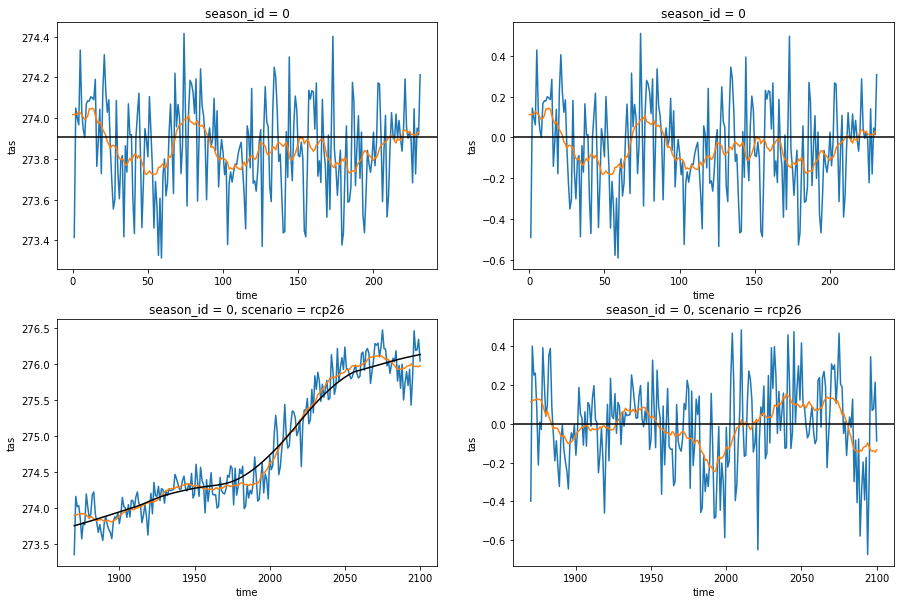

In [355]:
fig, axes = plt.subplots(2,2)

target_sel = target.isel(time=np.arange(0, len(arr['time'])))
target_res_sel = target_res.isel(time=np.arange(0, len(arr['time'])))

target_sel.plot.line(ax=axes[0, 0])
axes[0, 0].plot(ev._smooth(target_sel.data))
axes[0, 0].axhline(target.mean('time'), color='k')

target_res_sel.plot.line(ax=axes[0, 1])
axes[0, 1].plot(ev._smooth((target_sel - target.mean('time'))))
axes[0, 1].axhline(0, color='k')

arr.plot.line(ax=axes[1, 0])
axes[1, 0].plot(arr['time'].data, ev._smooth(arr.data))
axes[1, 0].plot(arr['time'].data, fit, color='k')

(arr - fit).plot.line(ax=axes[1, 1])
axes[1, 1].plot(arr['time'].data, ev._smooth(arr - fit))
axes[1, 1].axhline(0, color='k')


In [391]:
arr = ds_forc.isel(ensemble=0).isel(scenario=0).isel(season_id=1)['pr'].squeeze()
target = ds_ctrl.isel(season_id=1)['pr'].squeeze()
target_res = (target - target.mean('time'))

fit, dd = ev.minimize_variance_difference(arr, target_res, full_output=True)

for key, value in dd.items():
    print('{}: {}'.format(key, value))

Difference in variances exceeded 10.0%


Optimization terminated successfully.
         Current function value: 0.843547
         Iterations: 9
         Function evaluations: 23
window_size_minimum: 33
array_variance_high: 2.2317984370963576e-14
array_variance_low: 5.35966067095897e-16
target_variance_high: 2.1444936233141803e-14
target_variance_low: 2.7183776303635744e-15
bartlett_test_high: 0.7073453053449523
bartlett_test_low: 1.2113226677831528e-36
permutation_test_high: 0.755
permutation_test_low: 0.0


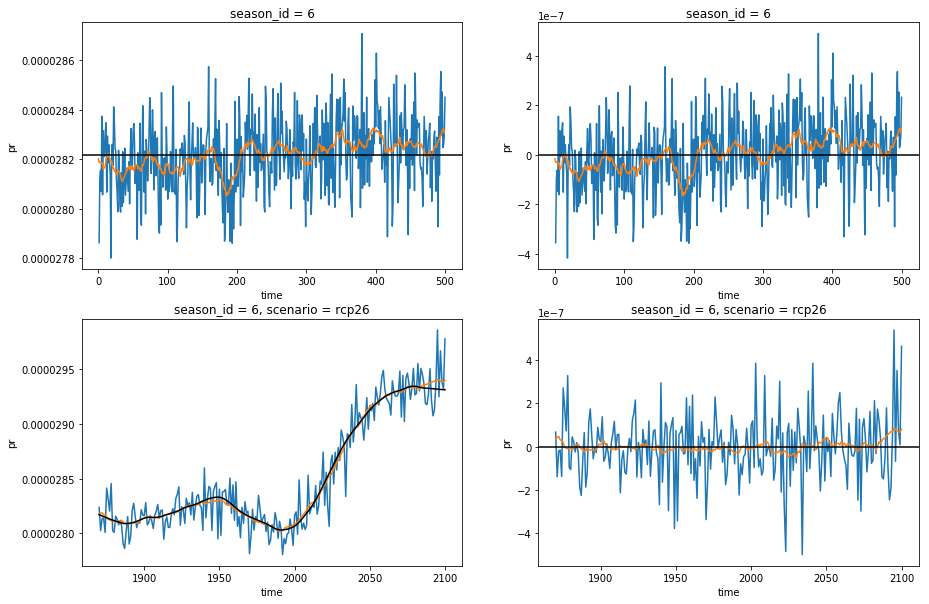

In [394]:
fig, axes = plt.subplots(2,2)

target_sel = target#.isel(time=np.arange(0, len(arr['time'])))
target_res_sel = target_res#.isel(time=np.arange(0, len(arr['time'])))

target_sel.plot.line(ax=axes[0, 0])
axes[0, 0].plot(ev._smooth(target_sel.data))
axes[0, 0].axhline(target.mean('time'), color='k')

target_res_sel.plot.line(ax=axes[0, 1])
axes[0, 1].plot(ev._smooth((target_sel - target.mean('time'))))
axes[0, 1].axhline(0, color='k')

arr.plot.line(ax=axes[1, 0])
axes[1, 0].plot(arr['time'].data, ev._smooth(arr.data))
axes[1, 0].plot(arr['time'].data, fit, color='k')

(arr - fit).plot.line(ax=axes[1, 1])
axes[1, 1].plot(arr['time'].data, ev._smooth(arr - fit))
axes[1, 1].axhline(0, color='k')


In [388]:
for ll in range(2, 12):
    ens = list(range(ll))

    arr = ds_forc.isel(ensemble=0).isel(scenario=0).isel(season_id=0)['tas'].squeeze()
    mean = ev._smooth(ds_forc.isel(ensemble=ens).mean('ensemble').isel(scenario=0).isel(season_id=0)['tas'], 91)
    target = ds_ctrl.isel(season_id=0)['tas'].squeeze()
    target_res = (target - target.mean('time'))

    fit, dd = ev.minimize_variance_difference(arr-mean, target_res, full_output=True)
    
    print('{}: {}'.format(ens, dd['window_size_minimum']))

#     fit += mean

#     for key, value in dd.items():
#         print('{}: {}'.format(key, value))

Optimization terminated successfully.
         Current function value: 0.025073
         Iterations: 18
         Function evaluations: 41
[0, 1]: 116
Optimization terminated successfully.
         Current function value: 0.025216
         Iterations: 18
         Function evaluations: 41
[0, 1, 2]: 116
Optimization terminated successfully.
         Current function value: 0.031923
         Iterations: 18
         Function evaluations: 41
[0, 1, 2, 3]: 116
Optimization terminated successfully.
         Current function value: 0.035734
         Iterations: 18
         Function evaluations: 41
[0, 1, 2, 3, 4]: 116
Optimization terminated successfully.
         Current function value: 0.032515
         Iterations: 18
         Function evaluations: 41
[0, 1, 2, 3, 4, 5]: 116
Optimization terminated successfully.
         Current function value: 0.034375
         Iterations: 18
         Function evaluations: 41
[0, 1, 2, 3, 4, 5, 6]: 116
Optimization terminated successfully.
         Current 

IndexError: index 10 is out of bounds for axis 1 with size 10

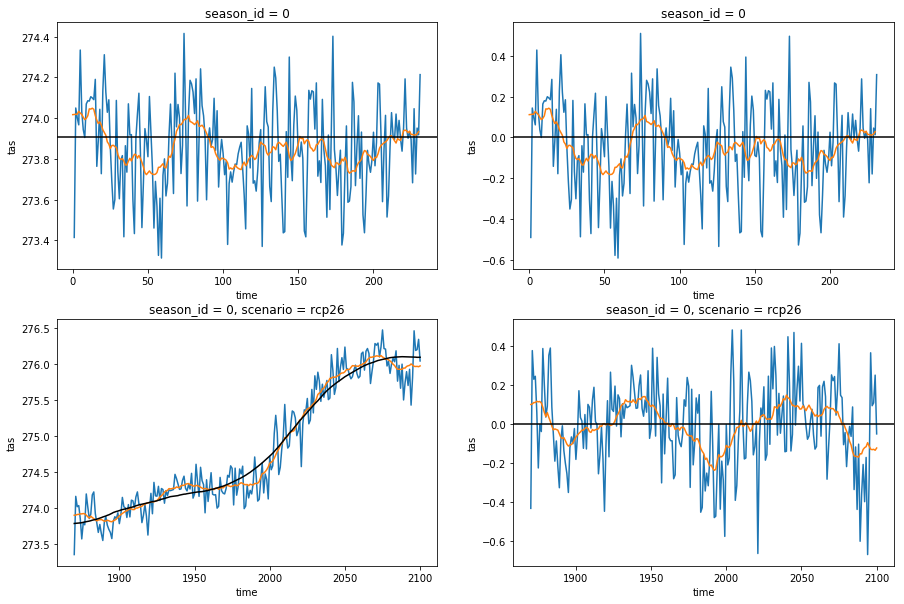

In [384]:
fig, axes = plt.subplots(2,2)

target_sel = target.isel(time=np.arange(0, len(arr['time'])))
target_res_sel = target_res.isel(time=np.arange(0, len(arr['time'])))

target_sel.plot.line(ax=axes[0, 0])
axes[0, 0].plot(ev._smooth(target_sel.data))
axes[0, 0].axhline(target.mean('time'), color='k')

target_res_sel.plot.line(ax=axes[0, 1])
axes[0, 1].plot(ev._smooth((target_sel - target.mean('time'))))
axes[0, 1].axhline(0, color='k')

arr.plot.line(ax=axes[1, 0])
axes[1, 0].plot(arr['time'].data, ev._smooth(arr.data))
axes[1, 0].plot(arr['time'].data, fit, color='k')

(arr - fit).plot.line(ax=axes[1, 1])
axes[1, 1].plot(arr['time'].data, ev._smooth(arr - fit))
axes[1, 1].axhline(0, color='k')